In [98]:
import numpy as np
from matplotlib import pyplot as plt

from collections import defaultdict
import uproot
import re
from glob import glob

In [99]:
files = glob("./*.root")
files

['./Out_DB.root',
 './Out_Signal.root',
 './Out_ST.root',
 './Out_W.root',
 './Out_DY.root',
 './Out_Data.root',
 './Out_TTbkg.root']

In [100]:
files = {}
for file in glob("./*.root"):
    name = re.findall(r".*_([A-z]*)\.root", file)[0]
    files[name] = uproot.open(file)


In [101]:
files

{'DB': <ReadOnlyDirectory '/' at 0x7f2580aefa60>,
 'Signal': <ReadOnlyDirectory '/' at 0x7f2581a5d750>,
 'ST': <ReadOnlyDirectory '/' at 0x7f2581a5f2e0>,
 'W': <ReadOnlyDirectory '/' at 0x7f2581a5f8b0>,
 'DY': <ReadOnlyDirectory '/' at 0x7f2581a5fe80>,
 'Data': <ReadOnlyDirectory '/' at 0x7f2581a38490>,
 'TTbkg': <ReadOnlyDirectory '/' at 0x7f2581a38a60>}

In [102]:
data_hists = list(files['Data'].classnames().keys())
data_hists

['h_Muon_eta;1',
 'h_Muon_pt;1',
 'h_Electron_eta;1',
 'h_Electron_pt;1',
 'Muon_Electron_invariant_mass;1',
 'leading_lepton_pt;1']

In [103]:
mc_hists = [re.findall(r"(.*);1", i)[0]+"_weighted;1" for i in data_hists]
mc_hists

['h_Muon_eta_weighted;1',
 'h_Muon_pt_weighted;1',
 'h_Electron_eta_weighted;1',
 'h_Electron_pt_weighted;1',
 'Muon_Electron_invariant_mass_weighted;1',
 'leading_lepton_pt_weighted;1']

In [104]:
df = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for sample in files:
    for hist in data_hists:
        if sample == 'Data':
            df[hist]['Data'][sample] = files[sample][hist].to_numpy()
        else:
            df[hist]['MC'][sample] = files[sample][hist.replace(";1", "_weighted;1")].to_numpy()

df

defaultdict(<function __main__.<lambda>()>,
            {'h_Muon_eta;1': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'MC': defaultdict(list,
                                      {'DB': (array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                                0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                                0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                                0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                                0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                                0.        ,  4.54794807,  6.03650868,  3.86538496,  5.89126556,
                                                6.59446272,  6.15980808,  7.95888413,  7.73123979,  8.64097737,
                         

In [130]:
def stacked_histo(n_data, n_mc: dict, title=None, xlabel=r"$p_{\mathrm{T}}$ [GeV]", savepath=None) -> None:
    fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios':[3,1]})
    if title:
        fig.suptitle(f"{title}")
    bottom = np.zeros(shape=n_data[0].shape)
    # sort n_mc by max
    n_mc_sorted = {key: value for key, value in sorted(n_mc.items(), key=lambda x: x[1][0].max())}
    for sample in n_mc_sorted:
        centers = (n_mc[sample][1][1:]+n_mc[sample][1][:-1])/2.
        width = centers[1]-centers[0]
        axs[0].bar(centers,n_mc[sample][0], width=width,bottom=bottom, align='center', label=sample)
        bottom+=n_mc[sample][0]
    centers_data = (n_data[1][1:]+n_data[1][:-1])/2.
    axs[0].errorbar(centers_data, n_data[0], yerr=np.sqrt(n_data[0]), fmt='.',label='data')
    axs[0].legend()
    axs[0].set_ylabel("N")
    xmin, xmax = axs[0].get_xbound()
    summed_mc = np.zeros(shape=n_mc[sample][0].shape) 
    for sample in n_mc:
        summed_mc+= n_mc[sample][0]
    ratio = n_data[0]/summed_mc
    data_err, mc_err = np.sqrt(n_data[0]), np.sqrt(summed_mc)
    ratio_err = np.sqrt((data_err/summed_mc)**2+(n_data[0]*mc_err/(summed_mc**2))**2)
    axs[1].errorbar(centers_data, ratio, yerr=ratio_err, fmt='.', label = 'ratio')
    axs[1].set_xbound(xmin,xmax)
    axs[1].axhline(1, color='k', linestyle='--')
    axs[1].set_xlabel(f"{xlabel}")
    axs[1].set_ylabel(f"Ratio")
    delta = np.abs(ratio-1)
    axs[1].set_ylim([1-(np.nanmax(delta)+0.1),1+(np.nanmax(delta)+0.1)])
    #axs[1].set_ybound([0.5,1.5])
    if savepath:
        plt.tight_layout()
        plt.savefig(f"{savepath}")
    plt.show()

/tmp/ipykernel_8821/3810505555.py:21: RuntimeWarning: invalid value encountered in divide
  ratio = n_data[0]/summed_mc
/tmp/ipykernel_8821/3810505555.py:23: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/summed_mc)**2+(n_data[0]*mc_err/(summed_mc**2))**2)


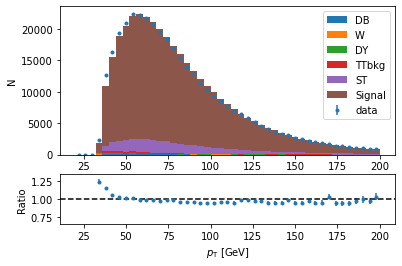

In [131]:
stacked_histo(n_data, n_mc,)

In [116]:
sorted(n_mc.items(), key=lambda x: x[1][0].max())

[('DB',
  (array([ 0.        ,  0.        ,  0.        ,  0.57882303, 19.88605351,
          24.78578512, 34.41923618, 27.53465714, 26.37677615, 26.3361129 ,
          25.5914127 , 27.14197542, 22.73880059, 18.08818717, 16.80626694,
          17.13694655, 15.04798912, 13.3335637 , 10.85299927,  9.73685625,
           6.92477242,  7.44182827,  8.88888585,  9.44683989,  4.96149878,
           4.15503141,  2.70797384,  4.25853655,  4.91976081,  3.39030201,
           2.62533768,  4.09326424,  2.39769334,  2.58359971,  2.31505718,
           1.73646909,  2.41856232,  1.75710313,  1.86060828,  1.28178525,
           2.33592616,  0.28941151,  0.57882303,  1.15764606,  1.83973929]),
   array([ 20.,  24.,  28.,  32.,  36.,  40.,  44.,  48.,  52.,  56.,  60.,
           64.,  68.,  72.,  76.,  80.,  84.,  88.,  92.,  96., 100., 104.,
          108., 112., 116., 120., 124., 128., 132., 136., 140., 144., 148.,
          152., 156., 160., 164., 168., 172., 176., 180., 184., 188., 192.,
          1

(array([ 0.        ,  0.        ,  0.        ,  0.57882303, 19.88605351,
       24.78578512, 34.41923618, 27.53465714, 26.37677615, 26.3361129 ,
       25.5914127 , 27.14197542, 22.73880059, 18.08818717, 16.80626694,
       17.13694655, 15.04798912, 13.3335637 , 10.85299927,  9.73685625,
        6.92477242,  7.44182827,  8.88888585,  9.44683989,  4.96149878,
        4.15503141,  2.70797384,  4.25853655,  4.91976081,  3.39030201,
        2.62533768,  4.09326424,  2.39769334,  2.58359971,  2.31505718,
        1.73646909,  2.41856232,  1.75710313,  1.86060828,  1.28178525,
        2.33592616,  0.28941151,  0.57882303,  1.15764606,  1.83973929]), array([ 20.,  24.,  28.,  32.,  36.,  40.,  44.,  48.,  52.,  56.,  60.,
        64.,  68.,  72.,  76.,  80.,  84.,  88.,  92.,  96., 100., 104.,
       108., 112., 116., 120., 124., 128., 132., 136., 140., 144., 148.,
       152., 156., 160., 164., 168., 172., 176., 180., 184., 188., 192.,
       196., 200.]))
(array([    0.        ,     0.      

In [112]:
x.items()

dict_items([(1, 2), (3, 4), (4, 3), (2, 1), (0, 0)])

In [91]:
sorted(x.items(), key=lambda item: item[0])

[(0, 0), (1, 2), (2, 1), (3, 4), (4, 3)]

-4.95 4.95
0.10000000000000053
-4.95 4.95
0.10000000000000053
-4.95 4.95
0.10000000000000053
-4.95 4.95
0.10000000000000053
-4.95 4.95
0.10000000000000053
-4.95 4.95
0.10000000000000053
-4.95 4.95


/tmp/ipykernel_8821/1636177737.py:21: RuntimeWarning: invalid value encountered in divide
  ratio = n_data[0]/summed_mc


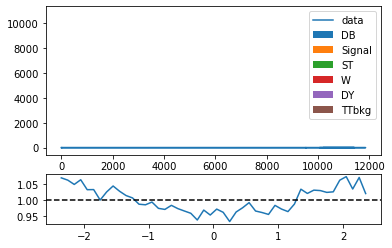

1.0 199.0
2.0
1.0 199.0
2.0
1.0 199.0
2.0
1.0 199.0
2.0
1.0 199.0
2.0
1.0 199.0
2.0
1.0 199.0


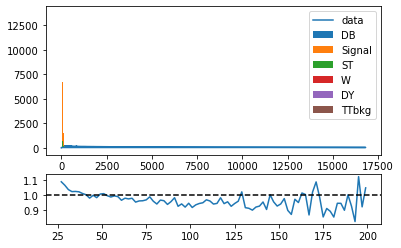

-4.95 4.95
0.10000000000000053
-4.95 4.95
0.10000000000000053
-4.95 4.95
0.10000000000000053
-4.95 4.95
0.10000000000000053
-4.95 4.95
0.10000000000000053
-4.95 4.95
0.10000000000000053
-4.95 4.95


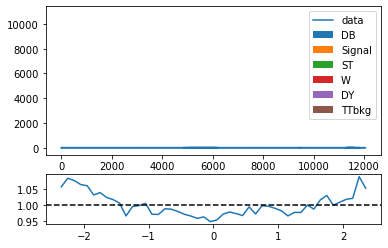

1.0 199.0
2.0
1.0 199.0
2.0
1.0 199.0
2.0
1.0 199.0
2.0
1.0 199.0
2.0
1.0 199.0
2.0
1.0 199.0


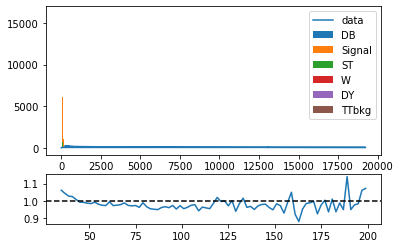

14.0 410.0
4.0
14.0 410.0
4.0
14.0 410.0
4.0
14.0 410.0
4.0
14.0 410.0
4.0
14.0 410.0
4.0
14.0 410.0


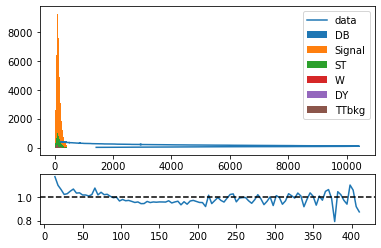

22.0 198.0
4.0
22.0 198.0
4.0
22.0 198.0
4.0
22.0 198.0
4.0
22.0 198.0
4.0
22.0 198.0
4.0
22.0 198.0


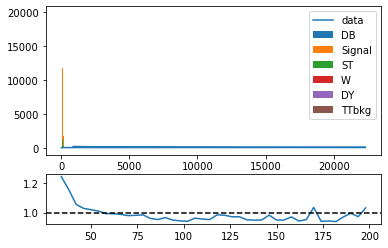

In [30]:
for hist in df:
    n_mc = df[hist]['MC']
    n_data = df[hist]['Data']['Data']
    stacked_histo(n_data, n_mc)

In [20]:
n_data

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,  2581.,  3082.,  3411.,  3968.,  4439.,  4979.,
         5295.,  6077.,  6828.,  7292.,  7755.,  8182.,  8477.,  9020.,
         9533.,  9517., 10291., 10835., 11121., 11346., 11403., 10194.,
        11610., 11699., 11853., 11493., 10054., 11387., 11420., 11284.,
        10600., 10076.,  9313.,  9312.,  8853.,  8153.,  7945.,  7807.,
         7163.,  6677.,  6047.,  5404.,  4910.,  4542.,  4024.,  3334.,
         3078.,  2473.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.]),
 array([-5. , -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4. ,
        -3.9, -3.8, 

In [3]:
diboson = uproot.open("./Out_DB.root")
mc_signal = uproot.open("./Out_Signal.root")
single_top = uproot.open("./Out_ST.root")
w = uproot.open("./Out_W.root")
drell_yann = uproot.open("./Out_DY.root")
ttbkgd = uproot.open("./Out_TTbkg.root")

data = uproot.open("./Out_Data.root")

In [4]:
data.classnames()

{'h_Muon_eta;1': 'TH1D',
 'h_Muon_pt;1': 'TH1D',
 'h_Electron_eta;1': 'TH1D',
 'h_Electron_pt;1': 'TH1D',
 'Muon_Electron_invariant_mass;1': 'TH1D',
 'leading_lepton_pt;1': 'TH1D'}

In [5]:
ttbkgd.classnames()

{'h_Muon_pt_weighted;1': 'TH1D',
 'h_Muon_eta_weighted;1': 'TH1D',
 'h_Electron_pt_weighted;1': 'TH1D',
 'h_Electron_eta_weighted;1': 'TH1D',
 'Muon_Electron_invariant_mass_weighted;1': 'TH1D',
 'leading_lepton_pt_weighted;1': 'TH1D'}

In [20]:
data_leading_lepton_pt =data['leading_lepton_pt;1'].to_numpy()
ttbkgd_leading_lepton_pt =ttbkgd['leading_lepton_pt_weighted;1'].to_numpy()
w_leading_lepton_pt =w['leading_lepton_pt_weighted;1'].to_numpy()
drell_yann_leading_lepton_pt =drell_yann['leading_lepton_pt_weighted;1'].to_numpy()
mc_signal_leading_lepton_pt =mc_signal['leading_lepton_pt_weighted;1'].to_numpy()
diboson_leading_lepton_pt =diboson['leading_lepton_pt_weighted;1'].to_numpy()
single_top_leading_lepton_pt =single_top['leading_lepton_pt_weighted;1'].to_numpy()

In [21]:
n_data, edges_data = data_leading_lepton_pt[0],data_leading_lepton_pt[1]

n_ttbkgd, edges_ttbkgd = ttbkgd_leading_lepton_pt[0], ttbkgd_leading_lepton_pt[1]
n_w, edges_w = w_leading_lepton_pt[0], w_leading_lepton_pt[1]
n_drell_yann, edges_drell_yann = drell_yann_leading_lepton_pt[0], drell_yann_leading_lepton_pt[1]
n_mc_signal, edges_mc_signal = mc_signal_leading_lepton_pt[0], mc_signal_leading_lepton_pt[1]
n_diboson, edges_diboson = diboson_leading_lepton_pt[0], diboson_leading_lepton_pt[1]
n_single_top, edges_single_top = single_top_leading_lepton_pt[0], single_top_leading_lepton_pt[1]

In [ ]:
n_ttbkgd

/tmp/ipykernel_13455/1014417298.py:17: RuntimeWarning: invalid value encountered in divide
  ratio = n_data/summed_mc


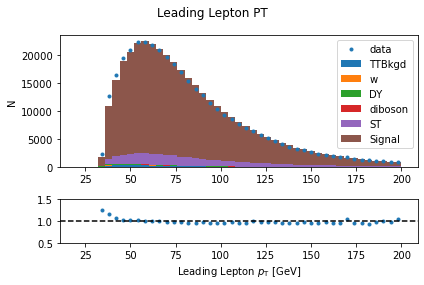

In [46]:

fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios':[3,1]})
fig.suptitle(f"Leading Lepton PT")
#axs[0].bar((edges_data[1:]+edges_data[:-1])/2.,n_data, width=edges_data[1]-edges_data[0], align='center', label="Data")
axs[0].bar((edges_ttbkgd[1:]+edges_ttbkgd[:-1])/2.,n_ttbkgd, width=edges_ttbkgd[1]-edges_ttbkgd[0], align='center', label="TTBkgd")
axs[0].bar((edges_w[1:]+edges_w[:-1])/2.,n_w,bottom=n_ttbkgd, width=edges_w[1]-edges_w[0], align='center', label="w")
axs[0].bar((edges_drell_yann[1:]+edges_drell_yann[:-1])/2.,n_drell_yann,bottom=n_ttbkgd+n_w, width=edges_drell_yann[1]-edges_drell_yann[0], align='center', label="DY")
axs[0].bar((edges_diboson[1:]+edges_diboson[:-1])/2.,n_diboson, bottom=n_ttbkgd+n_w+n_drell_yann,width=edges_diboson[1]-edges_diboson[0], align='center', label="diboson")
axs[0].bar((edges_single_top[1:]+edges_single_top[:-1])/2.,n_single_top, bottom=n_ttbkgd+n_w+n_drell_yann+n_diboson,width=edges_single_top[1]-edges_single_top[0], align='center', label="ST")
axs[0].bar((edges_mc_signal[1:]+edges_mc_signal[:-1])/2.,n_mc_signal,bottom =  n_ttbkgd+n_w+n_drell_yann+n_diboson+n_single_top,width=edges_mc_signal[1]-edges_mc_signal[0], align='center', label="Signal")
n_data_ = n_data.copy() 
n_data_[n_data_ == 0] = np.nan
axs[0].plot((edges_data[1:]+edges_data[:-1])/2.,n_data_,'.', label='data')
axs[0].set_ylabel(r'N')
axs[0].legend()
xmin, xmax =axs[0].get_xbound()
summed_mc = n_ttbkgd+n_w+ n_drell_yann+ n_mc_signal+ n_diboson+ n_single_top
ratio = n_data/summed_mc
#ratio[np.isnan(ratio)] = 0.
axs[1].plot((edges_data[1:]+edges_data[:-1])/2., ratio, '.', label = 'ratio')
axs[1].axhline(1, color='k', linestyle='--')
axs[1].set_ylim([0.5, 1.5])
axs[1].set_xbound(xmin, xmax)
axs[1].set_xlabel(r'Leading Lepton $p_{\mathrm{T}}$ [GeV]')
plt.tight_layout()
plt.savefig("./Leading_Lepton_pt.pdf")
plt.show()

In [31]:
def stacked_histo(n_data, n_mc: dict, title=None) -> None:
    fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios':[3,1]})
    if title:
        fig.suptitle(f"{title}")
    bottom = np.zeros(shape=n_data[0].shape)
    for sample in n_mc:
        centers = (n_mc[sample][1][1:]+n_mc[sample][1][:-1])/2.
        width = centers[1]-centers[0]
        axs[0].bar(centers,n_mc[sample][0], width=width,bottom=bottom, align='center', label=sample)
        bottom=n_mc[sample][0]
    centers_data = (n_data[1][1:]+n_data[1][:-1])/2.
    axs[0].plot(n_data[0], centers_data, label='data')
    axs[0].legend()
    xmin, xmax = axs[0].get_xbound()
    summed_mc = np.zeros(shape=n_mc[sample][0].shape) 
    for sample in n_mc:
        summed_mc+= n_mc[sample][0]
    ratio = n_data/summed_mc
    axs[1].set_xbound(xmin,xmax)
    axs[1].plot(centers_data, ratio, label = 'ratio')
    axs[1].axhline(1, color='k', linestyle='--')
    plt.show()

array([    0.        ,     0.        ,     0.        ,  1846.63645304,
       10947.71123481, 15560.96486054, 18868.52798836, 20518.16303056,
       22124.42266901, 22413.00937069, 21964.70985645, 21119.08282233,
       20004.27585525, 18761.25979623, 17313.89266464, 15953.226295  ,
       14583.48722734, 13281.08185151, 12052.4658599 , 10950.48412927,
        9899.09788939,  8913.57666086,  8040.12467511,  7262.43389067,
        6527.48676413,  5860.54997389,  5316.51580228,  4749.3662322 ,
        4272.01594527,  3848.5499944 ,  3480.91829708,  3140.22427838,
        2813.36508682,  2536.2192318 ,  2300.60287456,  2073.27352654,
        1893.63706448,  1690.72305214,  1534.57376023,  1397.79109835,
        1256.47989164,  1128.39127883,  1022.63340746,   941.23214386,
         853.14949258])

In [32]:
n_data

array([    0.,     0.,     0.,  2295., 12649., 16421., 19401., 20918.,
       22346., 22247., 21793., 20861., 19588., 18410., 17046., 15322.,
       13894., 12830., 11441., 10337.,  9313.,  8576.,  7687.,  6918.,
        6428.,  5754.,  5163.,  4614.,  4062.,  3651.,  3307.,  3085.,
        2670.,  2408.,  2233.,  1954.,  1804.,  1749.,  1444.,  1318.,
        1180.,  1095.,  1018.,   915.,   880.])

In [33]:
n_data/summed_mc

/tmp/ipykernel_13455/2648628192.py:1: RuntimeWarning: invalid value encountered in divide
  n_data/summed_mc


array([       nan,        nan,        nan, 1.24280012, 1.15540132,
       1.05526875, 1.02822011, 1.01948698, 1.01001506, 0.99259317,
       0.99218247, 0.98777964, 0.97919066, 0.98127739, 0.9845273 ,
       0.96043269, 0.95272137, 0.96603576, 0.94926633, 0.94397653,
       0.9407928 , 0.96212781, 0.9560797 , 0.95257322, 0.98475879,
       0.98181912, 0.97112474, 0.97149804, 0.95083915, 0.94866898,
       0.95003666, 0.98241391, 0.94904142, 0.94944474, 0.97061515,
       0.94247092, 0.95266407, 1.03446865, 0.9409779 , 0.94291629,
       0.93913162, 0.97040807, 0.99546914, 0.97213   , 1.03147222])

In [112]:
files = {}
for file in glob("./*.root"):
    name = re.findall(r".*_([A-z]*)\.root", file)[0]
    files[name] = uproot.open(file)


In [113]:
files

{'DB': <ReadOnlyDirectory '/' at 0x7fc716975c60>,
 'Signal': <ReadOnlyDirectory '/' at 0x7fc714f4b730>,
 'ST': <ReadOnlyDirectory '/' at 0x7fc7151f0e50>,
 'W': <ReadOnlyDirectory '/' at 0x7fc7151cddb0>,
 'DY': <ReadOnlyDirectory '/' at 0x7fc7151cebf0>,
 'Data': <ReadOnlyDirectory '/' at 0x7fc7151cfaf0>,
 'TTbkg': <ReadOnlyDirectory '/' at 0x7fc7155b1150>}

In [114]:
files['DB'].classnames()

{'h_Muon_eta;1': 'TH1D',
 'h_Muon_pt;1': 'TH1D',
 'Muon_pt;1': 'TH1D',
 'Muon_eta;1': 'TH1D',
 'h_Muon_eta_weighted;1': 'TH1D',
 'h_Muon_pt_weighted;1': 'TH1D',
 'Muon_pt_weighted;1': 'TH1D',
 'Muon_eta_weighted;1': 'TH1D',
 'h_Electron_eta;1': 'TH1D',
 'h_Electron_pt;1': 'TH1D',
 'Electron_pt;1': 'TH1D',
 'Electron_eta;1': 'TH1D',
 'h_Electron_eta_weighted;1': 'TH1D',
 'h_Electron_pt_weighted;1': 'TH1D',
 'Electron_pt_weighted;1': 'TH1D',
 'Electron_eta_weighted;1': 'TH1D',
 'Muon_Electron_invariant_mass;1': 'TH1D',
 'Muon_Electron_invariant_mass_weighted;1': 'TH1D',
 'leading_lepton_pt;1': 'TH1D',
 'leading_lepton_pt_weighted;1': 'TH1D',
 'Run_out;1': 'TTree'}

['h_Muon_eta;1',
 'h_Muon_pt;1',
 'h_Electron_eta;1',
 'h_Electron_pt;1',
 'Muon_Electron_invariant_mass;1',
 'leading_lepton_pt;1']

['h_Muon_eta_weighted;1',
 'h_Muon_pt_weighted;1',
 'h_Electron_eta_weighted;1',
 'h_Electron_pt_weighted;1',
 'Muon_Electron_invariant_mass_weighted;1',
 'leading_lepton_pt_weighted;1']

In [117]:
n_edges_mc = defaultdict(lambda: defaultdict(list))

for hist in data_hists:
    for sample in ['DB', 'Signal', 'ST', 'W', 'DY', 'TTbkg']:
        if sample == 'Data':
            n_, edges = files[sample][hist].to_numpy()
            centers = (edges[:-1]+edges[1:])/2.
            n_edges_mc[hist][sample].append(n_)
            n_edges_mc[hist][sample].append(centers)
        else:
            sum_w = sum(files[sample]['Run_out']['genEventSumw'].array())
            n_, edges = files[sample][hist.replace(';1', '_weighted;1')].to_numpy()
            centers = (edges[:-1]+edges[1:])/2.
            n_edges_mc[hist][sample].append(n_*1000./sum_w)
            n_edges_mc[hist][sample].append(centers)


In [120]:
n_edges_data = defaultdict(list)
for hist in data_hists:
    n_, edges = files['Data'][hist].to_numpy()
    centers = (edges[:-1]+edges[1:])/2.
    n_edges_data[hist].append(n_)
    n_edges_data[hist].append(centers)

[-4.95 -4.85 -4.75 -4.65 -4.55 -4.45 -4.35 -4.25 -4.15 -4.05 -3.95 -3.85
 -3.75 -3.65 -3.55 -3.45 -3.35 -3.25 -3.15 -3.05 -2.95 -2.85 -2.75 -2.65
 -2.55 -2.45 -2.35 -2.25 -2.15 -2.05 -1.95 -1.85 -1.75 -1.65 -1.55 -1.45
 -1.35 -1.25 -1.15 -1.05 -0.95 -0.85 -0.75 -0.65 -0.55 -0.45 -0.35 -0.25
 -0.15 -0.05  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95
  1.05  1.15  1.25  1.35  1.45  1.55  1.65  1.75  1.85  1.95  2.05  2.15
  2.25  2.35  2.45  2.55  2.65  2.75  2.85  2.95  3.05  3.15  3.25  3.35
  3.45  3.55  3.65  3.75  3.85  3.95  4.05  4.15  4.25  4.35  4.45  4.55
  4.65  4.75  4.85  4.95]
(99,) (100,)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (99,) and arg 1 with shape (100,).

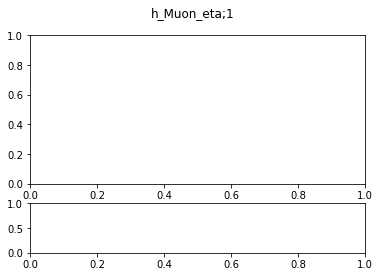

In [137]:
def stacked_histo(n_data, n_mc: dict, edges: np.array) -> None:
    centers = (edges[1:]+edges[:-1])/2.
    width = centers[1]-centers[0]
    fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios':[3,1]})
    fig.suptitle(f"{hist}")
    for sample in n_mc:
        print(centers.shape, n_mc[sample].shape)
        axs[0].bar(centers,n_mc[sample], width=width, align='center', label=sample)
    axs[0].plot(n_data, edges, label='data')
    axs[0].legend()
    summed_mc = np.sum(n_mc)
    ratio = n_data/summed_mc
    axs[1].plot(edges, ratio, label = 'ratio')
    axs[1].axhline(1, color='k', linestyle='--')
    plt.show()



samples = n_edges_mc[hist].keys()
for hist in n_edges_data:
    n_data = n_edges_data[hist][0]
    n_mc = {sample: n_edges_mc[hist][sample][0] for sample in samples}
    edges = n_edges_data[hist][1]
    print(edges)
    stacked_histo(n_data, n_mc, edges)

/tmp/ipykernel_30023/133628709.py:15: RuntimeWarning: invalid value encountered in divide
  ratio = data_n / summed_bkgd


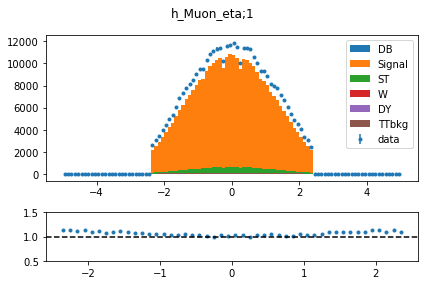

/tmp/ipykernel_30023/133628709.py:15: RuntimeWarning: invalid value encountered in divide
  ratio = data_n / summed_bkgd


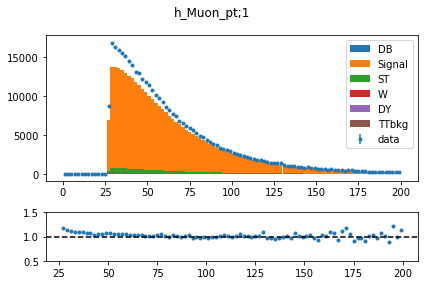

/tmp/ipykernel_30023/133628709.py:15: RuntimeWarning: invalid value encountered in divide
  ratio = data_n / summed_bkgd


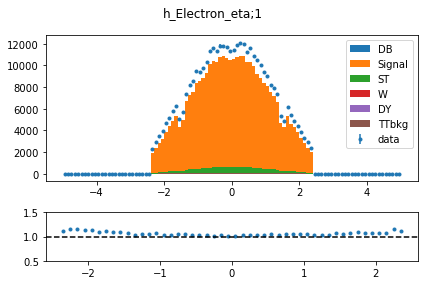

/tmp/ipykernel_30023/133628709.py:15: RuntimeWarning: invalid value encountered in divide
  ratio = data_n / summed_bkgd


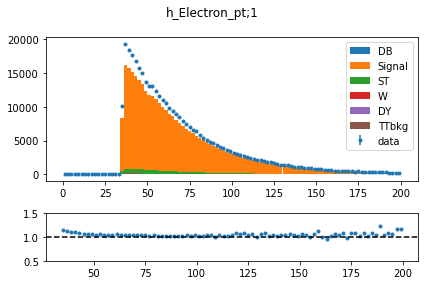

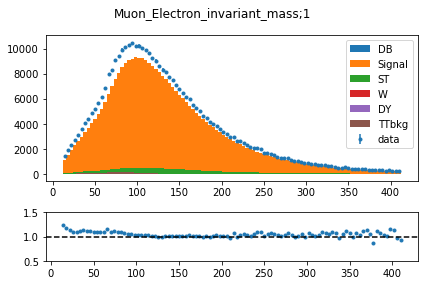

/tmp/ipykernel_30023/133628709.py:15: RuntimeWarning: invalid value encountered in divide
  ratio = data_n / summed_bkgd


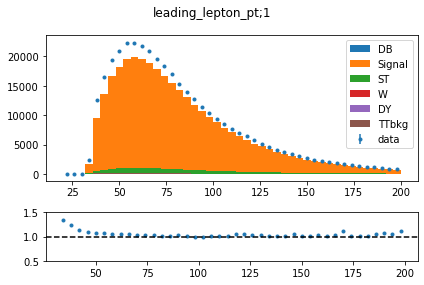

In [162]:
for hist in n_edges.keys():
    summed_bkgd = np.zeros(shape=n_edges[hist][sample][0].shape)
    fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios':[3,1]})
    fig.suptitle(f"{hist}")
    for sample in n_edges[hist].keys():
        if sample == 'Data':
            axs[0].errorbar(n_edges[hist][sample][1], n_edges[hist][sample][0], yerr=np.sqrt(n_edges[hist][sample][0]), fmt='.', label='data')
            data_n = n_edges[hist][sample][0]
        else:
            summed_bkgd += n_edges[hist][sample][0]
            centers = n_edges[hist]['Data'][1]
            axs[0].bar(centers, n_edges[hist][sample][0], width=centers[1]-centers[0], align='center', label=sample)

        axs[0].legend()
    ratio = data_n / summed_bkgd 
    axs[1].plot(n_edges[hist][sample][1], ratio, '.', label = 'ratio')
    axs[1].axhline(1, color='k', linestyle='--')
    axs[1].set_ylim([0.5,1.5])
    plt.tight_layout()
    plt.savefig(hist.replace(";1", "")+".pdf")
    plt.show()

In [154]:
hist.replace(";1", "")

'leading_lepton_pt'

In [84]:
def stacked_histo(n_data, n_mc, edges):
    centers = (edges[1:]+centers[:-1])/2.
    width = centers[1]-centers[0]
    fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios':[3,1]})
    fig.suptitle(f"{hist}")
    for n in n_mc:
        axs[0].bar(n, edges, width=4, align='center', label=sample)
    axs[0].plot(n_data, edges, label='data')
    axs[0].legend()
    summed_mc = np.sum(n_mc)
    ratio = n_data/summed_mc
    axs[1].plot(edges, ratio, label = 'ratio')
    axs[1].axhline(1, color='k', linestyle='--')
    plt.show()

In [81]:
files

{'DB': <ReadOnlyDirectory '/' at 0x7fc715e179a0>,
 'Signal': <ReadOnlyDirectory '/' at 0x7fc724f186d0>,
 'ST': <ReadOnlyDirectory '/' at 0x7fc716190df0>,
 'W': <ReadOnlyDirectory '/' at 0x7fc716190a00>,
 'DY': <ReadOnlyDirectory '/' at 0x7fc716190d90>,
 'Data': <ReadOnlyDirectory '/' at 0x7fc716190a90>,
 'TTbkg': <ReadOnlyDirectory '/' at 0x7fc716192d40>}

In [83]:
files['Data'].classnames()

{'h_Muon_eta;1': 'TH1D',
 'h_Muon_pt;1': 'TH1D',
 'h_Electron_eta;1': 'TH1D',
 'h_Electron_pt;1': 'TH1D',
 'Muon_Electron_invariant_mass;1': 'TH1D',
 'leading_lepton_pt;1': 'TH1D'}

In [86]:
hists = files['Data'].classnames().keys()
n_data = {hist: files['Data'][hist].to_numpy() for hist in hists} 

In [ ]:
mc_hists = [i.replace(";1", "_weighted;1") for i in hists]
n_mc = {}
for sample in ['DB', 'Signal', 'ST', 'W', 'DY', 'TTbkg', 'Data']:


In [66]:
glob("./*.root")

['./Out_DB.root',
 './Out_Signal.root',
 './Out_ST.root',
 './Out_W.root',
 './Out_DY.root',
 './Out_Data.root',
 './Out_TTbkg.root']

In [67]:
data = uproot.open("./Out_Data.root")

In [68]:
data.classnames()

{'h_Muon_eta;1': 'TH1D',
 'h_Muon_pt;1': 'TH1D',
 'h_Electron_eta;1': 'TH1D',
 'h_Electron_pt;1': 'TH1D',
 'Muon_Electron_invariant_mass;1': 'TH1D',
 'leading_lepton_pt;1': 'TH1D'}

In [71]:
n_data, edges_data = data['leading_lepton_pt;1'].to_numpy()

In [77]:
n_data

array([    0.,     0.,     0.,  2295., 12649., 16421., 19401., 20918.,
       22346., 22247., 21793., 20861., 19588., 18410., 17046., 15322.,
       13894., 12830., 11441., 10337.,  9313.,  8576.,  7687.,  6918.,
        6428.,  5754.,  5163.,  4614.,  4062.,  3651.,  3307.,  3085.,
        2670.,  2408.,  2233.,  1954.,  1804.,  1749.,  1444.,  1318.,
        1180.,  1095.,  1018.,   915.,   880.])

In [87]:
from collections import defaultdict
d = defaultdict(lambda: defaultdict(list))
for i in range(5):
    for j in ['a', 'b', 'c', 'd']:
        d[i][j].append(np.random.randint(10))

d

defaultdict(<function __main__.<lambda>()>,
            {0: defaultdict(list, {'a': [8], 'b': [9], 'c': [0], 'd': [6]}),
             1: defaultdict(list, {'a': [9], 'b': [4], 'c': [1], 'd': [4]}),
             2: defaultdict(list, {'a': [1], 'b': [6], 'c': [4], 'd': [5]}),
             3: defaultdict(list, {'a': [5], 'b': [2], 'c': [5], 'd': [6]}),
             4: defaultdict(list, {'a': [2], 'b': [6], 'c': [0], 'd': [8]})})

In [69]:
a = np.random.randint(0 ,10, size = (3, 2, 2))
a

array([[[4, 9],
        [9, 1]],

       [[8, 9],
        [4, 8]],

       [[3, 4],
        [1, 5]]])

In [80]:
np.sum(a, axis=1)

array([[13, 10],
       [12, 17],
       [ 4,  9]])